## <center> **Анализ результатов A/B-тестирования**

Компания планирует запустить новую акцию, чтобы продать как можно больше туров. Команда разработала два варианта посадочной страницы официального сайта компании и провела A/B-тестирование. Собранные в результате проведения эксперимента данные вы можете найти здесь.

Вам предстоит решить настоящую бизнес-задачу: проанализировать эффективность обоих вариантов посадочной страницы сразу по двум критериям: конверсии покупки и среднему чеку. На основе проведенного анализа вам будет необходимо сделать выводы и принять решение: какой из вариантов дизайна более предпочтительный.

Итак, наша фирма предлагает следующие варианты туров и их соответствующие стоимости:
* Таиланд — 100000 рублей;
* Турция — 60000 рублей;
* Мальдивы — 200000 рублей;
* Санкт-Петербург — 10000 рублей;
* Камчатка — 150000 рублей.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy.stats import t
from scipy.stats import ttest_ind, shapiro, f_oneway, mannwhitneyu
from statsmodels.stats.proportion import proportions_ztest

Прочитаем наши данные и посмотрим на столбцы таблицы:

In [3]:
data = pd.read_csv('../data/ab_data_tourist.csv')
data

,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0
2,661590,2021-01-11,B,0,0
3,853541,2021-01-08,B,0,0
4,864975,2021-01-21,A,1,150000
...,...,...,...,...,...
294473,751197,2021-01-03,A,0,0
294474,945152,2021-01-12,A,0,0
294475,734608,2021-01-22,A,0,0
294476,697314,2021-01-15,A,0,0


## **Задание 7.1.**

Начнем с исследования структуры наших данных. С помощью метода info() выведите информацию о типах данных и количестве непустых значений. Какой тип данных имеет столбец date?

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   user_id   294478 non-null  int64 
 1   date      294478 non-null  object
 2   group     294478 non-null  object
 3   purchase  294478 non-null  int64 
 4   price     294478 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 11.2+ MB


## **Задание 7.2.**

Приведите столбец date к типу данных datetime. Убедитесь в равной длительности проведения тестирования для каждой из группы. Для этого сгруппируйте данные по признаку группы и определите первую и последнюю дату наблюдения для каждой из групп. 

В какой промежуток времени проводился A/B-тест?


In [5]:
data['date'] = pd.to_datetime(data['date'])

data.groupby('group').date.agg(['min', 'max'])

,min,max
group,,
A,2021-01-02,2021-01-24
B,2021-01-02,2021-01-24


## **Задание 7.3.**

* Чему равно количество посещений сайта в группах А и B?

* Чему равно суммарное количество покупок в группах А и B?

* Чему равна сумма всех покупок в группах А и B? Ответ приведите в миллионах рублей. Например, 185.52 млн. руб.

In [6]:
data.groupby('group').agg({'user_id': 'count', 'purchase': 'sum', 'price': 'sum'})

,user_id,purchase,price
group,,,
A,147202,17723,1436260000
B,147276,17514,1554100000


## **Задание 7.4.**

Проверьте, есть ли пользователи, которые в процессе A/B-теста попали в обе тестовые группы? Если да, то сколько таких уникальных пользователей, если нет - введите в поле для ответа 0?

**Подсказка:**

*Создайте множество пользователей группы А и множество пользователей группы B. Пересеките два этих множества (операция intersection) и вычислите количество элементов в полученном множестве.*


In [7]:
user_id_a = set(data[data['group'] == 'A']['user_id'])
user_id_b = set(data[data['group'] == 'B']['user_id'])

user_intersection = user_id_a.intersection(user_id_b)
print(len(user_intersection))

1895


## **Исключите пользователей, оказавшихся в обеих группах**

Так как мы не можем определить, какая из версий сайта повлияла на принятие решения, исключим этих пользователей. Далее мы будем работать только с очищенными от пересечений данными.

Возможный вариант исключения пользователей:

In [8]:
updated_data = data[data['user_id'].apply(lambda x: x not in user_intersection)]

display(updated_data)

,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0
2,661590,2021-01-11,B,0,0
3,853541,2021-01-08,B,0,0
4,864975,2021-01-21,A,1,150000
...,...,...,...,...,...
294473,751197,2021-01-03,A,0,0
294474,945152,2021-01-12,A,0,0
294475,734608,2021-01-22,A,0,0
294476,697314,2021-01-15,A,0,0


Где user_intersection - множество пересечений пользователей групп А и B.

## **Задание 7.5.**

Для первичного анализа результатов A/B-тестирования нам понадобится таблица следующего вида:

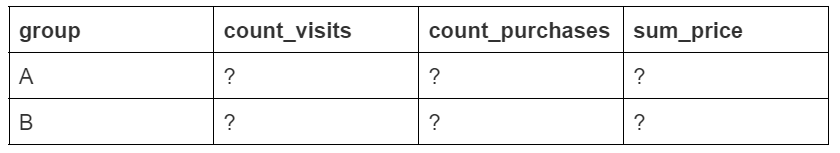
 
 
Для того, чтобы получить такую таблицу, сгруппируйте данные по признаку группы. В каждой группе рассчитайте следующие показатели:
* количество посещений (количество пользователей)
* количество совершенных покупок
* сумма всех покупок в группе

В полученной сгруппированной таблице переименуйте столбцы на **count_visits, count_purchases и sum_price**.

**Подсказка:**

*Для переименования столбцов можно использовать метод rename() с параметром columns, в который передается словарь. Ключи этого словаря - старые имена столбцов, а значения - новые.*

Чему на этот раз равно количество посещений сайта в группах А и B?


In [9]:
updated_data_grouped = updated_data.groupby('group').agg({'user_id': 'count', 'purchase': 'sum', 'price': 'sum'}).rename(columns={'user_id': 'count_visits', 'purchase': 'count_purchases', 'price': 'sum_price'})
display(updated_data_grouped)

,count_visits,count_purchases,sum_price
group,,,
A,145307,17487,1417780000
B,145381,17290,1533010000


Приведите промежуточные выводы по построенной таблице. Сопоставимо ли количество посещений обоих вариантов посадочной странице, можно ли говорить о сбалансированности выборок?

Количество посетителей в выборках А и Б отличаются на 0.013%. Выборки А и Б сбалансированны по количеству пользователей.

## **Задание 7.6.**

Добавьте в сгруппированную таблицу столбцы conversion - конверсия покупки (отношение количества покупок к количеству посещений сайта в каждой группе, выраженное в процентах) и mean_check - средний чек (отношение суммы покупок к количеству покупок в каждой группе).

* Чему равна конверсия в группах? Ответ приведите в процентах и округлите до сотых. Например, 75.12 %
* Чему равен средний чек в группах? Ответ приведите в рублях и округлите до целых. Например, 120519 рублей.

In [10]:
updated_data_grouped['conversion'] = updated_data_grouped['count_purchases'] / updated_data_grouped['count_visits'] * 100
updated_data_grouped['mean_check'] = updated_data_grouped['sum_price'] / updated_data_grouped['count_purchases']

display(updated_data_grouped)

,count_visits,count_purchases,sum_price,conversion,mean_check
group,,,,,
A,145307,17487,1417780000,12.034520,81076.228055
B,145381,17290,1533010000,11.892888,88664.545980


Приведите промежуточные выводы по таблице. По какому(им) показателю(ям) вариант А эффективнее варианта B и наоборот?

Интересной особенностью является то, что в группе А конверсия в покупку выше, а общая выручка ниже чем в группе Б. Вариант А более эффективен в плане конверсии в покупку. Вариант Б - с точки зрения среднего чека. Вообще, такие результаты наводят на подозрение и вызывают желание перепроверить правильность разделения пользователей на группы.

## **Задание 7.7.**

Теперь давайте сравним варианты по покупательской способности туров. Для этого постройте сводную таблицу, которая покажет зависимость количества продаж от группы и цены тура. 

In [11]:
updated_data_pt = updated_data[updated_data['purchase'] != 0].pivot_table(
    values='purchase',
    aggfunc='count',
    index='group',
    columns='price'
)

display(updated_data_pt)

price,10000,60000,100000,150000,200000
group,,,,,
A,5182,5271,1832,3478,1724
B,5201,1730,5227,3438,1694


Визуализируйте полученную сводную таблицу с помощью тепловой карты с аннотацией. 
Чему равно количество проданных туров за 60000 рублей в группах?

[Text(0.5, 70.61999999999998, 'Стоимость тура, руб.'),
 Text(69.0, 0.5, 'Группа')]

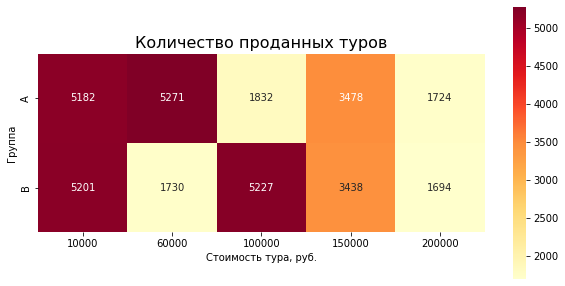

In [12]:
fig01 = plt.figure(figsize=(10, 5))
fig01_content = sns.heatmap(data=updated_data_pt, fmt=".0f", cmap='YlOrRd', annot=True, square=True)
fig01_content.set_title('Количество проданных туров', fontsize=16)
fig01_content.set(xlabel='Стоимость тура, руб.', ylabel='Группа')

Сделайте выводы по построенной таблице. По каким турам покупательская способность участников группы А выше, чем участников группы B и наоборот?

Пользователи из группы А покупают больше туров чем пользователи из группы Б в следующих ценовых категориях: 60000₽, 150000₽, 200000₽. Причем наибольшее различие в количестве покупок наблюдается в турах стоимостью 60000₽.
Данный факт может быть связан не с покупательность способностью/платежноспособностью клиентов. Возможно была допущена ошибка на этапе разделения пользователей на группы: при проектировании или реализации механизма распределения.     

## **Задание 7.8.**

Настало время поговорить о стабилизации кумулятивных метрик во времени. Но прежде, чем перейти к кумулятивным метрикам, нам необходимо построить таблицу с ежедневными данными результатов проведения A/B-тестирования.

Сгруппируйте данные по дате и группе тестирования. В каждой группе вычислите количество посещений страницы, количество покупок и сумму покупок. 

Добавьте в таблицу информацию о ежедневной конверсии (ежедневное количество покупок / ежедневное количество посещений) в группе и ежедневном среднем чеке (ежедневная сумма покупок / ежедневное количество покупок)
* Чему равна конверсия 3 января 2021 года? Ответ приведите в процентах и округлите до сотых.

* Чему равен средний чек 3 января 2021 года? Ответ приведите в рублях и округлите до целого.

In [13]:
updated_data_grouped02 = updated_data.groupby(['date', 'group'], as_index=False).agg({'user_id': 'count', 'purchase': 'sum', 'price': 'sum'}).rename(columns={'user_id': 'count_visits', 'purchase': 'count_purchases', 'price': 'sum_price'})

updated_data_grouped02['conversion'] = updated_data_grouped02['count_purchases'] / updated_data_grouped02['count_visits'] * 100
updated_data_grouped02['mean_check'] = updated_data_grouped02['sum_price'] / updated_data_grouped02['count_purchases']

display(updated_data_grouped02)

,date,group,count_visits,count_purchases,sum_price,conversion,mean_check
0,2021-01-02,A,2854,359,29410000,12.578837,81922.005571
1,2021-01-02,B,2861,345,29660000,12.058721,85971.014493
2,2021-01-03,A,6596,748,62000000,11.340206,82887.700535
3,2021-01-03,B,6619,754,65960000,11.391449,87480.106101
4,2021-01-04,A,6566,799,64250000,12.168748,80413.016270
5,2021-01-04,B,6536,764,68030000,11.689106,89044.502618
6,2021-01-05,A,6433,790,64550000,12.280429,81708.860759
7,2021-01-05,B,6511,749,63550000,11.503609,84846.461949
8,2021-01-06,A,6606,764,63410000,11.565244,82997.382199
9,2021-01-06,B,6751,838,75020000,12.412976,89522.673031


## **Задание 7.9.** 

Добавьте в таблицу с ежедневными показателями кумулятивные признаки:
* кумулятивное количество посещений страницы
* кумулятивное количество покупок
* кумулятивную сумму покупок

Не забудьте при расчете кумулятивной суммы сгруппировать данные по группам. 

Вычислите кумулятивную конверсию и кумулятивный средний чек на основе полученных кумулятивных показателей. 

* Какая **кумулятивная** конверсия была в группе B на 20 января? Ответ приведите в процентах, округлив до сотых.
* Какой **кумулятивный** средний чек был в группе А на 12 января 2021 года? Ответ приведите в рублях, округлив до целых.

In [14]:
updated_data_grouped02['cum_visits'] = updated_data_grouped02.groupby('group')['count_visits'].cumsum()
updated_data_grouped02['cum_purchases'] = updated_data_grouped02.groupby('group')['count_purchases'].cumsum()
updated_data_grouped02['cum_price'] = updated_data_grouped02.groupby('group')['sum_price'].cumsum()

updated_data_grouped02['cum_conversion'] = updated_data_grouped02['cum_purchases'] / updated_data_grouped02['cum_visits'] * 100
updated_data_grouped02['cum_mean_check'] = updated_data_grouped02['cum_price'] / updated_data_grouped02['cum_purchases']

display(updated_data_grouped02)

,date,group,count_visits,count_purchases,sum_price,conversion,mean_check,cum_visits,cum_purchases,cum_price,cum_conversion,cum_mean_check
0,2021-01-02,A,2854,359,29410000,12.578837,81922.005571,2854,359,29410000,12.578837,81922.005571
1,2021-01-02,B,2861,345,29660000,12.058721,85971.014493,2861,345,29660000,12.058721,85971.014493
2,2021-01-03,A,6596,748,62000000,11.340206,82887.700535,9450,1107,91410000,11.714286,82574.525745
3,2021-01-03,B,6619,754,65960000,11.391449,87480.106101,9480,1099,95620000,11.592827,87006.369427
4,2021-01-04,A,6566,799,64250000,12.168748,80413.016270,16016,1906,155660000,11.900599,81668.415530
5,2021-01-04,B,6536,764,68030000,11.689106,89044.502618,16016,1863,163650000,11.632118,87842.190016
6,2021-01-05,A,6433,790,64550000,12.280429,81708.860759,22449,2696,220210000,12.009444,81680.267062
7,2021-01-05,B,6511,749,63550000,11.503609,84846.461949,22527,2612,227200000,11.594975,86983.154671
8,2021-01-06,A,6606,764,63410000,11.565244,82997.382199,29055,3460,283620000,11.908449,81971.098266
9,2021-01-06,B,6751,838,75020000,12.412976,89522.673031,29278,3450,302220000,11.783592,87600.000000


Постройте кумулятивные графики конверсии и среднего чека в каждой группе по дням. Сделайте выводы. Можно ли назвать A/B-тест завершенным - стабилизировались ли значения метрик во времени? Как соотносятся кумулятивные показатели в каждой группе?

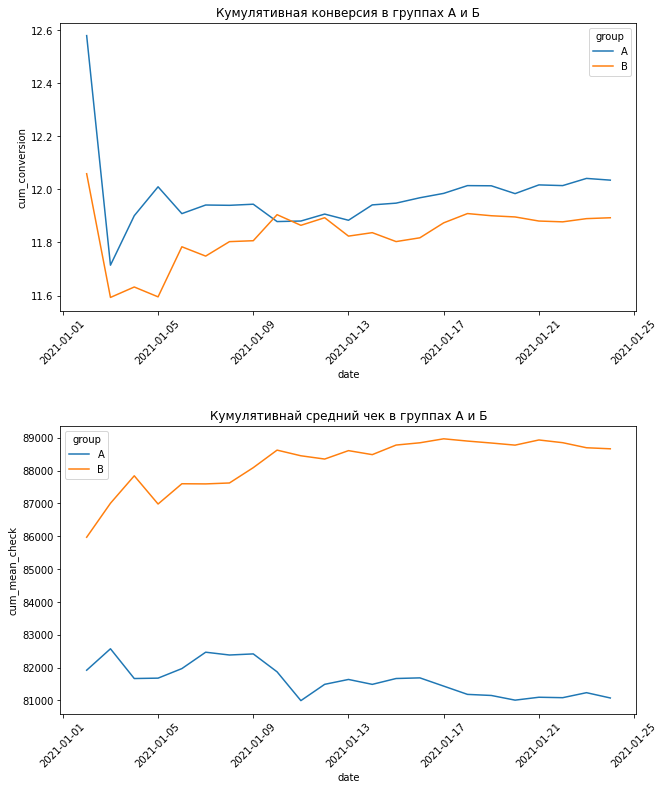

In [15]:
fig02 = plt.figure(figsize=(8, 4))

ax01 = fig02.add_axes([1, 2.4, 1, 1])
fig02_ax01_content = sns.lineplot(data=updated_data_grouped02, x='date', y='cum_conversion',  ax=ax01, hue='group')
fig02_ax01_content.set_title('Кумулятивная конверсия в группах А и Б', fontsize=12)
ax01.xaxis.set_tick_params(rotation = 45)

ax02 = fig02.add_axes([1, 1, 1, 1])
fig02_ax02_content = sns.lineplot(data=updated_data_grouped02, x='date', y='cum_mean_check',  ax=ax02, hue='group')
fig02_ax02_content.set_title('Кумулятивнай средний чек в группах А и Б', fontsize=12)
ax02.xaxis.set_tick_params(rotation = 45)

Кумулятивные метрики во времени стабилизировались. Конверсия на всем протяжении теста была выше в группе А за исключением 10 января 2021 года. Кумулятивный средний чек стабильно выше в группе Б.

## **Задание 7.10.**

Настало время переходить к проверке статистической значимости разницы между метриками в группах. Начнем с конверсии.

Какой тест вы примените для проверки гипотезы о равенстве конверсий в группах?

Проведите тестирование при следующих нулевой и альтернативной гипотезе:
* $H_0$: Конверсии в группах А и B равны; 
* $H_1$: Конверсия в группе А больше чем конверсия в группе B;

Вычислите p-value вашего теста для конверсий в группах А и B. Сравните полученное значение p-value с уровнем значимости $\alpha$=0.05. 

In [17]:
ztest_data = updated_data_grouped02.groupby('group').agg({'count_visits': 'sum', 'count_purchases': 'sum'}).rename(columns={'count_visits': 'nobs', 'count_purchases': 'count'})
#display(ztest_data)
alpha = 0.05

_, p01 = proportions_ztest(
	count=ztest_data['count'],
    nobs=ztest_data['nobs'],
    alternative='larger'
)

if p01 > alpha:
	print(f'Конверсия в группах одинаковая, p-value={p01}')
else:
	print(f'Конверсия в группе А больше чем в группе Б, p-value={p01}')

Конверсия в группах одинаковая, p-value=0.11970374924914917


Приведите свои выводы по результатам проведенного статистического теста. Есть ли статистическая разница между конверсиями в группах А и B?

Независимый Z-тест для пропорций не дал опровержения нулевой гипотизы, которая заключается в том что группы А и Б имеют равные конверсии, следовательно конверсии в группах равны.

## **Задание 7.11.**
Убедитесь в своих рассуждениях, построив 95%-ый доверительный интервал для конверсий и разницы между ними. Используйте $z_{крит}$ в своих расчетах

Укажите нижнюю и верхнюю границы доверительных интервалов. Границы приведите в процентах и округлите до 2 знака после запятой. Например: нижняя граница 89.24%, верхняя граница 91.25%.

In [29]:
def proportions_conf_interval(n, x_p, gamma=0.95):   
    alpha = 1 - gamma
    z_crit = -norm.ppf(alpha/2)
    eps = z_crit * (x_p * (1 - x_p) / n) ** 0.5
    lower_bound = x_p - eps
    upper_bound = x_p + eps
    return round(lower_bound * 100, 2), round(upper_bound * 100, 2)

def diff_proportions_conf_interval(n, x_p, gamma=0.95):
    alpha = 1 - gamma
    diff = x_p[1] - x_p[0]
    z_crit = -norm.ppf(alpha/2)
    eps = z_crit * (x_p[0] * (1 - x_p[0])/n[0] + x_p[1] * (1 - x_p[1])/n[1]) ** 0.5
    lower_bound = diff - eps
    upper_bound = diff + eps
    return round(lower_bound *100, 2), round(upper_bound * 100, 2)


n = [updated_data_grouped02[updated_data_grouped02['group'] == 'A']['count_visits'].sum(), updated_data_grouped02[updated_data_grouped02['group'] == 'B']['count_visits'].sum()]
#n=[500000,500000]
#display(n)
x_p = [updated_data_grouped02[updated_data_grouped02['group'] == 'A']['count_purchases'].sum() / updated_data_grouped02[updated_data_grouped02['group'] == 'A']['count_visits'].sum(), updated_data_grouped02[updated_data_grouped02['group'] == 'B']['count_purchases'].sum() / updated_data_grouped02[updated_data_grouped02['group'] == 'B']['count_visits'].sum()]

print(f'Доверительный интервал конверсии для группы А ', proportions_conf_interval(n = n[0], x_p = x_p[0]))
print(f'Доверительный интервал конверсии для группы Б ', proportions_conf_interval(n = n[1], x_p = x_p[1]))
print(f'Доверительный интервал разности конверсий', diff_proportions_conf_interval(n = n, x_p = x_p))

Доверительный интервал конверсии для группы А  (11.87, 12.2)
Доверительный интервал конверсии для группы Б  (11.73, 12.06)
Доверительный интервал разности конверсий (-0.38, 0.09)


Проинтерпретируйте построенные доверительные интервалы для конверсий в группах. Есть ли перекрытие между доверительными интервалами для групп? Есть ли статистическая разница между конверсиями в группах А и B?

Доверительные интервалы конверсий в группах имеют значительное перекрытие. Доверительный интервал для разности конверсий захватквает нулевую ноль. Это говорит о том, что с 95% уверенностью можно утверждать что нет разницы в конверсиях между группами А и Б. Таким образом можно утверждать что нет статистической разницы в конверсиях.

## **Задание 7.12.**

Ранее мы построили таблицу с ежедневными показателями. Теперь она нам снова понадобится, так как нас интересует ежедневный средний чек.

Проверьте гипотезу о нормальности распределения ежедневного среднего чека в каждой из групп тестирования. 

* Какой тест вы примените  для проверки гипотезы о нормальности распределения ежедневного среднего чека?
* Как будут звучать нулевая и альтернативная гипотезы?
* Каковы результаты статистического теста с уровнем значимости $\alpha$ =0.05?

In [ ]:
def norm_test_result(p, alpha, group_id):
	H0 = 'Данные распределены нормально'
	Ha = 'Данные не распределены нормально'
	
	if p > alpha:
		print(f'{H0} в группе {group_id}, p-value={p}')
	else:
		print(f'{Ha} в группе {group_id}, p-value={p}')

_, p02 = shapiro(updated_data_grouped02[updated_data_grouped02['group'] == 'A']['mean_check'])
norm_test_result(p=p01, alpha=alpha, group_id='A')

_, p03 = shapiro(updated_data_grouped02[updated_data_grouped02['group'] == 'B']['mean_check'])
norm_test_result(p=p02, alpha=alpha, group_id='B')

Данные распределены нормально в группе A, p-value=0.2937832772731781
Данные распределены нормально в группе B, p-value=0.25307759642601013


## **Задание 7.13.**
Настало время сравнить варианты дизайна страницы по метрике среднего чека. 

Какой тест вы примените для проверки гипотезы о равенстве средних чеков по дням в группах?

Проведите тестирование при следующих нулевой и альтернативной гипотезе:
* $H_0$: Ежедневные средние чеки в группах А и B равны; 
* $H_1$: Ежедневный средний чек в группе А меньше чем в группе B;

Вычислите p-value вашего теста для ежедневного среднего чека в группах А и B. Сравните полученное значение p-value с уровнем значимости $\alpha$ =0.05. 

In [ ]:
alpha02 = 0.05

_, p04 = ttest_ind(
    a=updated_data_grouped02[updated_data_grouped02['group'] == 'A']['mean_check'],
    b=updated_data_grouped02[updated_data_grouped02['group'] == 'B']['mean_check'], 
    alternative='less'
)

if p04 > alpha02:
	print(f'Средний чек в группах не отличается, p-value={p04}')
else:
	print(f'Средний чек в группе А меньше чем в группе Б, p-value={p04}')

Средний чек в группе А меньше чем в группе Б, p-value=1.1261794674808954e-12


 Приведите свои выводы по проведенному статистическому тесту. Есть ли статистическая разница между ежедневными средними чеками в группах А и B?

p-value статистического теста оказалось меньше уровня значимости, что отвергает нулевую гипотезу о раменстве среденего чека в генеральной совокупности. Следодвательно принимается альтернативная гипотеза, которая заключается в том, что Средний чек в группе А ниже чем в группе Б. Это статиситески значимое утверждение.

## **Задание 7.14.**

Постройте 95%-ый доверительный интервал для среднего чека в каждой группе. Так как выборка средних чеков небольшая, используйте  $t_{крит}$ в своих расчетах.

Укажите нижнюю границу доверительного интервала для истинного среднего чека каждой из групп. Ответ приведите в процентах и округлите до целого.

In [ ]:
def conf_int(n, x_mean, x_std, gamma=0.95):
    alpha = 1 - gamma
    t_crit = -t.ppf(alpha/2, n-1)
    eps = t_crit * x_std/(n ** 0.5)
    #display(f'T-критическое: {t_crit}')
    #display(f'Погрешность: +/-{eps}')
    return (x_mean - eps, x_mean + eps)

print(f'Доверительный интервал конверсии для группы А ', conf_int(n = len(updated_data_grouped02[updated_data_grouped02['group'] == 'A']), x_mean = updated_data_grouped02[updated_data_grouped02['group'] == 'A']['mean_check'].mean(), x_std = updated_data_grouped02[updated_data_grouped02['group'] == 'A']['mean_check'].std()))
print(f'Доверительный интервал конверсии для группы Б ', conf_int(n = len(updated_data_grouped02[updated_data_grouped02['group'] == 'B']), x_mean = updated_data_grouped02[updated_data_grouped02['group'] == 'B']['mean_check'].mean(), x_std = updated_data_grouped02[updated_data_grouped02['group'] == 'B']['mean_check'].std()))

Доверительный интервал конверсии для группы А  (79630.35138233882, 82308.21881567157)
Доверительный интервал конверсии для группы Б  (87625.82583631018, 89525.6051909103)


Проинтерпретируйте построенные доверительные интервалы для ежедневных средних чеков в группах. Есть ли между ними пересечения?

Доверительные интервалы истинного среденего чека в группах А и Б не пересекаются. Это говорит о том что есть статистическая значимость у результатов теста, который говорит о том, что средний чек в группе Б выше чем в группе А.

## **Сделайте общий вывод по результатам A/B-теста**

Какой варианта дизайна посадочной страницы является более эффективным в комплексе по метрикам конверсии и среднего чека и почему? 

Варианты А и Б равнозначны с точки зрения конверсии в покупку. Это заключение следует из проведенных статистических тестов на равнозначность конверсий в двух группах. Этот вывод так же подтверждают доверительные интервалы для конверсии, которые имеют болльшое пересечение.

Одновременно вариант Б имеет преимущество в среднем чеке, что видно из проведенного независимого Т-теста и постороенных доверительных интервалов для среднего чека в группах А и Б.

Из этого можно сделать вывод о том, что реализация страницы Б увеличит выручку сервиса и его следует выбрать в качестве основного варианта страницы.

На мой взглад, отдельного внимания заслуживает тот факт, что конверсия в группе А значительно выше чем в группе Б в кагорте покупателей туров за 60 т. р. (см. задание 7.7). Это может быть вызвано ошибкой в распределении пользователей в ходе теста, либо у страницы А есть что-то, что побуждает пользователй покупать именно эти туры (возможно рекламная ссылка). Я бы порекомендовал провести дополнительное исследование этой аномалии.